From the file phase1_import_tweets.py I imported 34339 tweets that contains any of these words Russia, Ukraine, or #UkraineRussiaWar.

#### Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn  as sns
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 # 1. Import Raw Data

#### Read raw Data to a Dataframe
After importing the tweets using the Twitter API in the import_tweets_hashtag.py file, we will read it using a dataframe, and check the shape and the missing data on the raw data

In [2]:
raw_df = pd.read_csv('./data/raw_data.csv')
#raw_df.sample(10)
raw_df.shape

(26000, 17)

#### Data Dictionary 

| Syntax                | Description |
| -----------           | ----------- |
|- tweetID :            | The unique identifier for Tweet. The dataset contain 34339 uniq tweets | 
|- tweetText :          | The actual text of the tweet |
|- tweetRetweetCt :     | Number of times this Tweet has been retweeted|
|- tweetFavoriteCt:     | Indicates approximately how many times this Tweet has been liked by Twitter users |
|- tweetCreated:        | UTC time when this Tweet was created  |
|- userID:              | The user ID who posted this Tweet |
|- userName:            | The user Name who posted this Tweet |
|- userLocation:        | The location of the user  |
|- Tweetcountry:        | The location of the user  |

<AxesSubplot:>

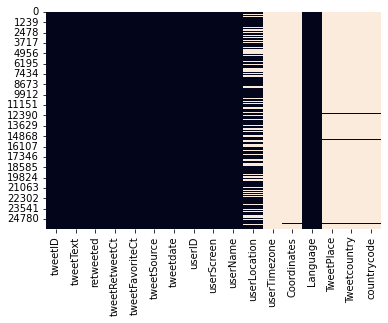

In [3]:
sns.heatmap(raw_df.isnull(), cbar=False)

#### Find and delete the duplicate tweets

In [4]:
#print(raw_df.tweetText.value_counts())
raw_df['duplicattweet'] = raw_df.duplicated(subset=['tweetText'], keep='first')
print(raw_df.duplicattweet.value_counts())
raw_df.drop(raw_df[raw_df.duplicattweet == True].index, inplace=True)
print(raw_df.duplicattweet.value_counts())

False    25957
True        43
Name: duplicattweet, dtype: int64
False    25957
Name: duplicattweet, dtype: int64


#### Chage the tweetdate column to datetime and extract only date to another column 

In [5]:
raw_df['tweetdate'] = pd.to_datetime(raw_df['tweetdate'])
raw_df['date'] = raw_df['tweetdate'].dt.date
raw_df.date.value_counts()

2022-02-28    25957
Name: date, dtype: int64

In [6]:
raw_df['Tweetcountry'].isnull().sum()

25635

# 2. Cleaning Process

#### Fill the missing of user location with tweet country

The process of obtaining country code is depend on the userlocation colume. it goes through long process 
I used the country_code.csv to create a dictionary 

In [ ]:
tweet_df = raw_df[['tweetText','tweetdate','date']]

Set xx value (Not Defined) in countrycode to all rows that have missing vlaue in both countrycode & userLocation

Set all null value in both countrycode and userLocation to Not Defined 

In [ ]:
tweet_df['countrycode'] = np.where(tweet_df['countrycode'].isnull() & tweet_df['userLocation'].isnull(), code_dic.get('Not Defined'), tweet_df['countrycode'])

In [ ]:
Key_word = 'Not Defined'
country_key = Key_word
country_Name = country_dic[Key_word]
print(code_dic.get(country_key))

In [ ]:
tweet_df[tweet_df['userLocation'].str.contains(country_Name,na=False) & tweet_df['countrycode'].isnull()]['userLocation']

In [ ]:
tweet_df['countrycode'] = np.where(tweet_df['userLocation'].str.contains(country_Name,na=False) & tweet_df['countrycode'].isnull(), code_dic.get(country_key), tweet_df['countrycode'])

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,10))
ax = sns.countplot(x="countrycode", data=tweet_df, order = tweet_df['countrycode'].value_counts().index)

In [ ]:
tweet_df.countrycode.isnull().sum()

In [ ]:
tweet_df.countrycode.value_counts()

## Text Pre-Processing

In [7]:
#tweet_df = pd.read_csv('./data/cleaned_data.csv')
tweet_df = raw_df[['tweetText','tweetdate','date']]

In [ ]:
tweet_df['tweetText'].head()

In [8]:
# source: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [9]:
# to add cleanText column to the the dataframe, this process take almost 2 min
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
    
tweet_df['cleanText'] = tweet_df['tweetText'].apply(lambda x: finalpreprocess(x))
tweet_df.head()

/tmp/ipykernel_22177/3883534920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['cleanText'] = tweet_df['tweetText'].apply(lambda x: finalpreprocess(x))


,tweetText,tweetdate,date,cleanText
0,@RealPepeEscobar Flush those fancy degrees dow...,2022-02-28 22:32:28+00:00,2022-02-28,realpepeescobar flush fancy degree toilet saw ...
1,"Hey @GrantRandom, while listening to @SXMOctan...",2022-02-28 22:32:28+00:00,2022-02-28,hey grantrandom listen sxmoctane late last nig...
2,Stephen King stands with #Ukraine!\n@StephenKi...,2022-02-28 22:32:28+00:00,2022-02-28,stephen king stand ukraine stephenking stephen...
3,@kilogolfsierra @form_whisperer @EdwardGLuce U...,2022-02-28 22:32:28+00:00,2022-02-28,kilogolfsierra form whisperer edwardgluce ukra...
4,@indiana_imo It's because Russia is a nuclear ...,2022-02-28 22:32:28+00:00,2022-02-28,indiana imo russia nuclear superpower aggressi...


In [20]:
# add aditional words to stopword list
stop_words = set(stopwords.words('english'))
additional_stopwords = {'I','-','&map','amp','would','this','we','the','you','co','http','https','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'}
stop_words.update(additional_stopwords)
#type(stop_words)
#print(stop_words)

# STOPWORD REMOVAL
def removestopword(string):
    a= [i for i in string.split() if i not in stop_words]
    return ' '.join(a)

In [21]:
tweet_df['cleanText'] = tweet_df['cleanText'].apply(lambda x: removestopword(x))

/tmp/ipykernel_22177/2460791469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['cleanText'] = tweet_df['cleanText'].apply(lambda x: removestopword(x))


In [ ]:
from collections import Counter
Counter(" ".join(tweet_df['cleanText']).split()).most_common(20)

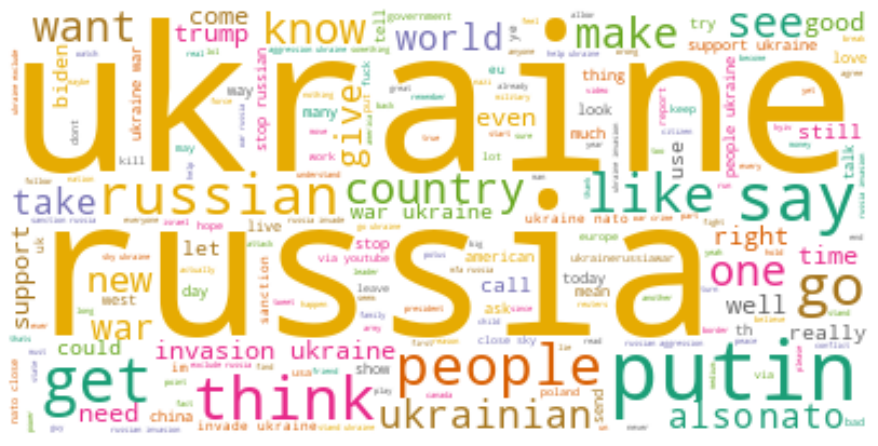

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

tweet_word = " ".join(title for title in tweet_df.cleanText)
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(tweet_word)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

### Extracting vectors from text (Vectorization)

In [23]:
import re
import string

def countWords(data_frame, selected_words):
    words_dict = {}
    
    for sentence in data_frame:
        remove = string.punctuation
        remove = remove.replace("'", "") # don't remove hyphens
        pattern = r"[{}]".format(remove) # create the pattern

        test = re.sub(pattern, "", str(sentence)) #compile

        splited_words = str(test).split(' ')

        for word in splited_words:
            word = word.strip()
            word = word.lower()
            if word in selected_words:
                if word not in words_dict:
                    words_dict[word] = 1
                else:
                    words_dict[word] += 1
    return words_dict

In [24]:
import pycountry
countries_list = []
for country in pycountry.countries:
     countries_list.append(country.name.lower())
countries_list.append('russia')
countries_list.append('us')
countries_list.append('england')
countries_list.append('saudi')

In [28]:
import operator
extracted_countries = countWords(tweet_df['cleanText'],countries_list)
print(dict(sorted(extracted_countries.items(), key=operator.itemgetter(1),reverse=True)))

{'ukraine': 13184, 'russia': 8878, 'china': 381, 'poland': 262, 'canada': 252, 'israel': 183, 'belarus': 181, 'germany': 115, 'turkey': 98, 'iraq': 95, 'india': 81, 'afghanistan': 72, 'finland': 70, 'switzerland': 57, 'ireland': 54, 'nigeria': 47, 'france': 46, 'hungary': 40, 'sweden': 34, 'georgia': 32, 'australia': 29, 'libya': 28, 'jordan': 26, 'cuba': 24, 'serbia': 24, 'yemen': 24, 'japan': 24, 'bulgaria': 23, 'romania': 23, 'saudi': 22, 'pakistan': 20, 'latvia': 19, 'brazil': 18, 'monaco': 17, 'mexico': 17, 'qatar': 15, 'somalia': 14, 'us': 13, 'estonia': 11, 'norway': 11, 'slovakia': 11, 'lithuania': 11, 'greece': 9, 'armenia': 9, 'egypt': 8, 'ethiopia': 8, 'azerbaijan': 8, 'myanmar': 7, 'italy': 6, 'england': 6, 'lebanon': 6, 'peru': 6, 'croatia': 6, 'jersey': 6, 'slovenia': 5, 'cyprus': 5, 'mali': 5, 'kenya': 4, 'argentina': 4, 'kuwait': 4, 'kazakhstan': 4, 'singapore': 4, 'netherlands': 4, 'spain': 4, 'congo': 4, 'portugal': 3, 'austria': 3, 'belize': 3, 'chile': 2, 'senegal':

In [26]:
def getkeyList(dict):
    return list(dict.keys())

def getvalueList(dict):
    return list(dict.values())

import random
def getcolorlist(count):
    color_list = []
    for i in range(count):
        color_list.append("#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)]))
    return color_list

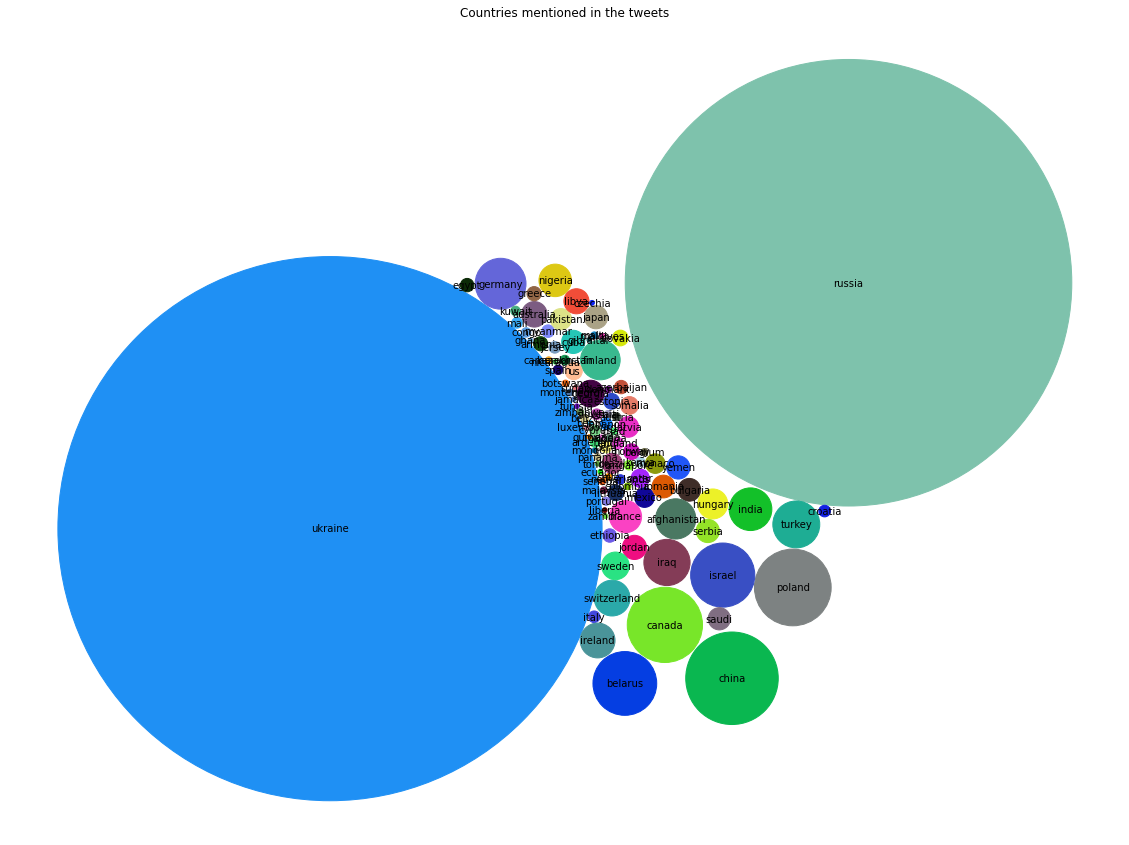

In [27]:
import numpy as np
import matplotlib.pyplot as plt

mentioned_countries = {
    'countries': getkeyList(extracted_countries),
    'freq': (getvalueList(extracted_countries)),
    'color': getcolorlist(len(extracted_countries.keys()))
}

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


bubble_chart = BubbleChart(area=mentioned_countries['freq'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(20,15))
bubble_chart.plot(
    ax, mentioned_countries['countries'], mentioned_countries['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Countries mentioned in the tweets')

plt.show()

In [29]:
def target_country (row):
   if 'ukraine' in row['cleanText'] :
      return 'ukraine'
   elif 'russia' in row['cleanText']:
      return 'russia'
   else:
      return 'na'

In [30]:
tweet_df['target'] = tweet_df.apply (lambda row: target_country(row), axis=1)

/tmp/ipykernel_22177/2262426310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['target'] = tweet_df.apply (lambda row: target_country(row), axis=1)


In [31]:
tweet_df.head()

,tweetText,tweetdate,date,cleanText,target
0,@RealPepeEscobar Flush those fancy degrees dow...,2022-02-28 22:32:28+00:00,2022-02-28,realpepeescobar flush fancy degree toilet saw ...,na
1,"Hey @GrantRandom, while listening to @SXMOctan...",2022-02-28 22:32:28+00:00,2022-02-28,hey grantrandom listen sxmoctane late last nig...,na
2,Stephen King stands with #Ukraine!\n@StephenKi...,2022-02-28 22:32:28+00:00,2022-02-28,stephen king stand ukraine stephenking stephen...,ukraine
3,@kilogolfsierra @form_whisperer @EdwardGLuce U...,2022-02-28 22:32:28+00:00,2022-02-28,kilogolfsierra form whisperer edwardgluce ukra...,ukraine
4,@indiana_imo It's because Russia is a nuclear ...,2022-02-28 22:32:28+00:00,2022-02-28,indiana imo russia nuclear superpower aggressi...,russia


In [32]:
ukraine_df = tweet_df.loc[(tweet_df['target'] == 'ukraine'), ['tweetText','cleanText']]
russia_df = tweet_df.loc[(tweet_df['target'] == 'russia'), ['tweetText','cleanText']]

In [33]:
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
from nrclex import NRCLex

ukraine_text_list = ukraine_df['cleanText'].to_list()
ukraine_emotion = []
for i in range(len(ukraine_text_list)):
    ukraine_emotion.append(NRCLex(ukraine_text_list[i]))

russia_text_list = russia_df['cleanText'].to_list()
russia_emotion = []
for i in range(len(russia_text_list)):
    russia_emotion.append(NRCLex(russia_text_list[i]))

In [34]:
ukraine_emotion_dic = {}   
ukraine_words = [] 
for i in range(len(ukraine_emotion)):
    ukraine_emotion_dic.update((ukraine_emotion[i]).raw_emotion_scores)
    ukraine_words.append((ukraine_emotion[i]).words)
#print(ukraine_emotion_dic)
#print(ukraine_words)

In [35]:
ukraine_emotion_dic = {}    
for i in range(len(ukraine_emotion)):
    ukraine_emotion_dic.update((ukraine_emotion[i]).raw_emotion_scores)
print(ukraine_emotion_dic)

{'positive': 1, 'fear': 3, 'negative': 4, 'sadness': 1, 'anger': 1, 'anticipation': 1, 'disgust': 1, 'surprise': 1, 'joy': 2, 'trust': 1}


In [36]:
russia_emotion_dic = {}    
for i in range(len(russia_emotion)):
    russia_emotion_dic.update((russia_emotion[i]).raw_emotion_scores)
print(russia_emotion_dic)

{'anger': 1, 'fear': 1, 'negative': 2, 'sadness': 1, 'surprise': 2, 'joy': 1, 'positive': 1, 'trust': 1, 'anticipation': 1, 'disgust': 1}


In [37]:
emotion_dic = {'ukraine':{} , 'russia':{}}
emotion_dic['ukraine'].update(ukraine_emotion_dic)
emotion_dic['russia'].update(russia_emotion_dic)

In [38]:
emotion_list = []
ukraine_emotion_value = []
russia_emotion_value = []

for emotion in ukraine_emotion_dic:
    if emotion not in emotion_list:
        emotion_list.append(emotion)
        ukraine_emotion_value.append(emotion_dic['ukraine'].get(emotion))
        russia_emotion_value.append(emotion_dic['russia'].get(emotion))

#print(emotion_list,ukraine_emotion_value,russia_emotion_value)
emotion_df = pd.DataFrame({'emotion':emotion_list,'ukraine':ukraine_emotion_value, 'russia':russia_emotion_value})
emotion_df

,emotion,ukraine,russia
0,positive,1,1
1,fear,3,1
2,negative,4,2
3,sadness,1,1
4,anger,1,1
5,anticipation,1,1
6,disgust,1,1
7,surprise,1,2
8,joy,2,1
9,trust,1,1


<AxesSubplot:xlabel='emotion'>

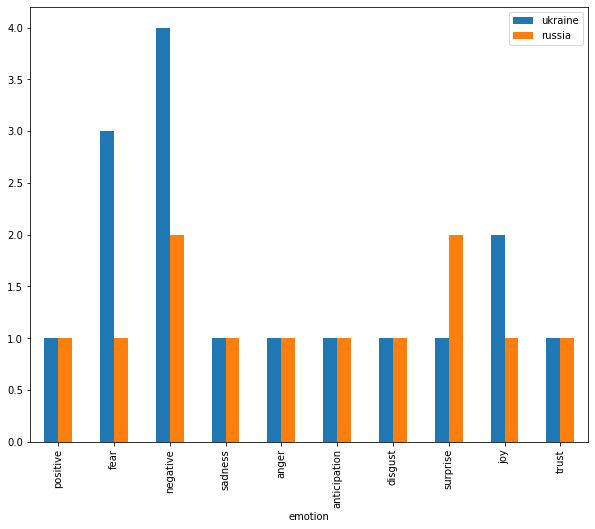

In [39]:
# plotting graph
emotion_df.plot(x="emotion", y=["ukraine", "russia"], kind="bar",figsize=(10,8))

In [40]:
ukraine_doc = ' '.join(x for x in  ukraine_df['cleanText'])

In [ ]:
print(ukraine_doc)

In [41]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(ukraine_doc)
noun_adj_pairs = []
for i,token in enumerate(doc):
    if token.pos_ not in ('NOUN','PROPN'):
        continue
    for j in range(i+1,len(doc)):
        if doc[j].pos_ == 'ADJ':
            noun_adj_pairs.append((token,doc[j]))
            break


In [ ]:
print(noun_adj_pairs)

In [ ]:
ukraine_df['tokenized_words'] = ukraine_df.apply(lambda row: nltk.word_tokenize(row['cleanText']), axis=1)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

words =  wc.generate_from_text(" ".join(ukraine_df['tokenized_words']))
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(words)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

-------------------------------------

In [ ]:
tweet_df['tokenized_sentence'] = tweet_df.apply(lambda row: nltk.sent_tokenize(row['cleanText']), axis=1)

In [ ]:
sentence_df = tweet_df['tokenized_sentence']

In [ ]:
sentence_df

In [ ]:
# Divide to words and sentence
tweet_df['tokenized_words'] = tweet_df.apply(lambda row: nltk.word_tokenize(row['tweetText']), axis=1)
tweet_df['tokenized_sentence'] = tweet_df.apply(lambda row: nltk.sent_tokenize(row['tweetText']), axis=1)

In [ ]:
stemmer = SnowballStemmer("english")
tweet_df['stemmed_sentence'] = tweet_df['tokenized_sentence'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

In [ ]:
tweet_df['stemmed_sentence']

In [ ]:
tweet_df['tokenized_words']

In [ ]:
from collections import Counter
Counter(" ".join(tweet_df['tweetText']).split()).most_common(10)

In [ ]:
tweet_df['stemmed_sentence'][1]

In [ ]:
tweet_df[tweet_df('stemmed_sentence')]

In [ ]:
tweet_df['tweetText']=tweet_df['tweetText'].str.replace(' saudi ',' saudi arabia ')
tweet_df['tweetText']=tweet_df['tweetText'].str.replace(' us ',' united states ')

In [ ]:
tweet_df.loc[tweet_df['tweetText'].str.contains('us'),'tweetText'] = tweet_df['tweetText'].str.replace(' us ',' united states ')

In [ ]:
#replace us with united states 
tweet_df.loc[tweet_df['tweetText'].str.contains('united states')]

In [ ]:
import pycountry
countries_list = []
for country in pycountry.countries:
     countries_list.append(country.name.lower())
countries_list.append('russia')
countries_list.append('us')

In [ ]:
extracted_countries = countWords(tweet_df['tweetText'],countries_list)

In [ ]:
countries_list

In [ ]:
dict(sorted(extracted_countries.items(), key=lambda item: item[1]))

In [ ]:
countries = (country.name for country in pycountry.countries)


In [ ]:
print(countries)

In [ ]:
tweet_df[tweet_df['country_in_text'].notnull()]

In [ ]:
tweet_df[tweet_df['tweetText'].str.contains(' saudi arabia ',na=False)]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

tweet_word = " ".join(title for title in tweet_df.cleanText)
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(tweet_word)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

All tweets contains ukraine but not russia

In [ ]:
included_word = 'saudi'
excluded_word = 'u'

tweet_word = " ".join(title for title in tweet_df[tweet_df['tweetText'].str.contains(included_word,na=False) & ~tweet_df['tweetText'].str.contains(excluded_word ,na=False)]['tweetText'])
plt.rcParams['figure.figsize'] = [10, 4]

cloud = wc.generate(tweet_word)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

In [ ]:
# Divide to words and sentence
tweet_df['tokenized_words'] = tweet_df.apply(lambda row: nltk.word_tokenize(row['tweetText']), axis=1)
tweet_df['tokenized_sentence'] = tweet_df.apply(lambda row: nltk.sent_tokenize(row['tweetText']), axis=1)

In [ ]:
tweet_df['tokenized_words']

In [ ]:
tweet_df['tokenized_sentence']

#### Save Cleaned Data

Save the cleaned data to cleaned_data.csv

In [ ]:
tweet_df = tweet_df[['tweetID','tweetText','tweetdate','date','countrycode']]
# Overwrite or add
ans = input('Do you want overwrite the file? (y/n): ')
if (ans == 'y'):
    tweet_df.to_csv('./data/cleaned_data.csv', index=False)
else:  
    # check if the file exist, it will add the data 
    try:
        with open('./data/cleaned_data.csv') as f:
            print('Add The data to the existing file')
            tweet_df.to_csv('./data/cleaned_data.csv',mode='a', header=False, index=False)
    except IOError:
       print('Create new file')
       tweet_df.to_csv('./data/cleaned_data.csv', index=False)

In [ ]:
cleaned_tweet_df = pd.read_csv('./data/cleaned_data.csv')
cleaned_tweet_df.shape

In [ ]:
cleaned_tweet_df.head()

---------------------------------------------------------------------------------------------------

# Under Development  